**VLSI CAD Assignment 2: FM ALGORITHM**
<br>
Submitted by: <br>


1.   Adithi S Upadhya (191EC101)
2.   Poorvi S.H.M (191EC229)



### Partitioning with Fiduccia-Mattheyses
Iterative graph partitioning heuristic <br>
Similar to KL, but moves only a single vertex at a time <br>
Operates in mulitple passes: <br>
* unlock all the vertices
* move one vertex at a time to improve the cut
* roll back to the best configuration seen



In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt 
import random
import networkx as nx

**Input format:** Number of blocks N, Dimension of each of the blocks (width, height), Adjacency matrix which is a N X N matrix. Each element in the adjacency matrix (i, j) gives the number of interconnects running between them. <br>
Example- <br>
{6, {10, 5}, {8, 6}, {4, 13}, {10, 3}, {8, 4}, {4, 1}} where the first data 6 indicates the number of blocks, then each of the six pairs of data enclosed in the flower braces specify {width, height} of the individual block.

The following 6X6 adjacency matrix gives the number of edges between the blocks.
  
{0 1 3 2 4 2<br>
 1 0 3 1 2 1<br>
 3 3 0 1 1 2<br>
 2 1 1 0 2 3<br>
 4 2 1 2 0 1<br>
 2 1 2 3 1 0}<br>


In [2]:
print("""The input format should be:
{n, (w1, y1), (w2, h2), ......(wn, hn)}
{m00 m01 m02....m0n
 m10 m11 m12....m1n
 ..................
 ..................
 mn0 mn1 mn2....mnn}""")
filename = input("Enter input file name eg-input.txt: ")

The input format should be:
{n, (w1, y1), (w2, h2), ......(wn, hn)}
{m00 m01 m02....m0n
 m10 m11 m12....m1n
 ..................
 ..................
 mn0 mn1 mn2....mnn}
Enter input file name eg-input.txt: input.txt


In [3]:
with open(filename, "r") as ip:
    inp = [line.strip() for line in ip]

# Removibg the '{}', n
dim = inp[0]
dim = dim.split(',') # The split() method splits a string into a list after breaking the given string by the specified separator.
N = int(dim[0].split('{')[1])
dim = dim[1:]
dim[len(dim)-1] = dim[len(dim)-1].split('}')[0]

# Getting the adjacency matrix
adj = []
for i in range(1, len(inp)):
    adj.append(inp[i].split())
    
adj[0][0] = adj[0][0].split('{')[1]
adj[N-1][N-1] = adj[N-1][N-1].split('}')[0]

adj_matrix = []
for a in adj:
    l = []
    for j in a:
        l.append(int(j))
    adj_matrix.append(list(l))
        
# Removing the '(' and ')'
pts = []    # Stores all the points, x-coordinates in even position and y-coordinates in odd position
for i in dim:
    i = i.strip() #returns a copy of the string with both leading and trailing characters removed (based on the string argument passed). 
    i = i.strip('(')
    i = i.strip(')')
    pts.append(int(i))
    
# Storing the points in [(x1,y1), (x2,y2),....(xn,yn)]
dim = []
i=0
while i!=len(pts):
    dim.append((pts[i], pts[i+1]))
    i += 2

In [4]:
print(N)
print(dim)
print(adj_matrix)

6
[(10, 5), (8, 6), (4, 13), (10, 3), (8, 4), (4, 1)]
[[0, 1, 3, 2, 4, 2], [1, 0, 3, 1, 2, 1], [3, 3, 0, 1, 1, 2], [2, 1, 1, 0, 2, 3], [4, 2, 1, 2, 0, 1], [2, 1, 2, 3, 1, 0]]


In [5]:
#N = 6
#dim = [(10,5),(8,6),(4,13),(10,3),(8,4),(4,1)]
#rows,cols = (N,N)
#adj_matrix = [[0]*cols]*rows
#adj_matrix = [[0, 1, 3, 2, 4, 2], [1, 0, 3, 1, 2, 1],[ 3, 3, 0, 1, 1, 2],[2, 1, 1, 0, 2, 3],[4, 2, 1, 2, 0, 1],[2, 1, 2, 3, 1, 0]]

In [6]:
def random_partition(V):
  random.shuffle(V)
  cut = int(N/2)
  A, B = np.sort(V[:cut]), np.sort(V[cut:])
  print(A)
  print(B)
  #pairs = len(A)*len(B)
  cut_size = 0
  for i in A:
    for j in B:
      cut_size = cut_size + adj_matrix[i][j]
  print("initial cut_size =" + str(cut_size))
  return A,B,cut_size

In [7]:
def area(A,dim):
  area_A = 0
  for i in A:
    area_A = area_A + dim[i][0]*dim[i][1]
  return area_A

In [8]:
def rf(area_A, area_B):
  r = area_A / (area_A + area_B)
  return r

In [9]:
def is_balanced(r, area_V, area_A, max_area):
  # Balance criterion 
  # [r.area(v) - area_MAX(v)] <= area(A) <= [r.area(v) + area_MAX(v)]
  LHS  = r*area_V - max_area 
  RHS = r*area_V + max_area
  if (area_A >= LHS and area_A <=RHS):
    return True
  else :
    return False 

In [10]:
def calculate_gain(A,B,c,adj_matrix): #partition A, B and block c 
  FS = 0 # FS(i) = number of nets that have i as the only cell in partition P containining i 
  TE = 0 # TE(i) = number of nets containing cell i and are entirely located in partition P containining i 
  if c in A:
    pB = B
    pA = A
  else :
    pB = A
    pA = B
  for j in pB: 
    if adj_matrix[c][j]!=0: 
      # block in partition B is connected to block c
      # check if its connected to any other block in partition A
      for i in pA:
        if i!=c and adj_matrix[i][j] == 0:
          FS = FS + 1
  for i in pA:
    if i!=c and adj_matrix[i][c]!=0:
      TE = TE + 1
  gain = FS - TE
  return gain

In [11]:
def calculate_parameters(N, dim, adj_matrix):
    V = list(range(N)) #listing all the vertices
    # Dividing nodes into 2 random groups A and B 
    A,B,cut_size = random_partition(V)
    # ratio factor r = [area(A)]/[area(A)+area(B)] where area(A), area(B) are the areas of the respective partitions 
    area_A = area(A,dim) 
    area_B = area(B,dim)
    AREA = []
    for i in range(len(dim)):
      AREA.append(dim[i][0] * dim[i][1])
    area_V = 0 
    max_area = max(AREA)
    area_V = area(V,dim)
    r = rf(area_A, area_B)
    return V,A,B,cut_size,area_A,area_B,area_V,max_area,r,AREA

In [12]:
def FM1(N, dim, adj_matrix,V,A,B,cut_size,area_A,area_B,area_V,max_area,r,AREA,locked):
  # Step 2: Calculate gains
  # gain = FS - TE
  gain = []
  for i in V:
    g = calculate_gain(A,B,i,adj_matrix)
    gain.append(g)
  # Step 3: find the base block, the one with max gain 
  sols = []
  min_area = max(AREA)
  temp = 0
  for i in range(len(gain)):
    if gain[i] == max(gain):
      sols.append(i)
  min = AREA[sols[0]]
  exchange = sols[0]
  for i in sols:
    #check balance criterion for each 
    if i in A:
      temp = area_A - AREA[i]
    else:
      temp = area_A + AREA[i]
    if is_balanced(r, area_V, area_A, max_area) and temp <= min:
      exchange = i
      min = temp
  locked.append(exchange)
  if exchange in A:
    A.remove(exchange)
    B.append(exchange)
  else:
    A.append(exchange)
    B.remove(exchange)
  return gain[exchange]

In [13]:
def FM_partitioning(N,dim,adj_matrix):
    V,a,b,cut_size,area_A,area_B,area_V,max_area,r,AREA = calculate_parameters(N, dim, adj_matrix)
    # Step 1: Balance criterion to be satisfied
    if is_balanced(r, area_V, area_A, max_area) == False:
      while is_balanced(r, area_V, area_A, max_area) == False:
        V,a,b,cut_size,area_A,area_B,area_V,max_area,r = calculate_parameters(N, dim, adj_matrix)
    locked = []
    iter_gain = []
    A = a.tolist()
    B = b.tolist()
    while len(locked)!=N:
      # update and run
      g = FM1(N, dim, adj_matrix,V,A,B,cut_size,area_A,area_B,area_V,max_area,r,AREA,locked)
      iter_gain.append(g)
    gain_sum = []
    l = 0
    for i in range(len(iter_gain)):
      l = l + iter_gain[i]
      gain_sum.append(l)
    # select max cummulative gain
    minArea = max_area # initialising to high value
    aA = area(a,dim)
    aB = area(b,dim)
    newA = a.tolist()
    newB = b.tolist()
    ans = 0
    for i in range(len(gain_sum)):
      if gain_sum[i] == max(gain_sum):
        for j in range(i):
          if j in a:
            aA = aA - dim[j][0] * dim[j][1]
          else:
            aA = aA + dim[j][0] * dim[j][1]
        if aA < minArea:
          minArea = aA
          ans = i
    print(ans)
    # final partitions
    for i in range(ans+1):
      if i in a:
        newA.remove(i)
        newB.append(i)
      else:
        newA.append(i)
        newB.remove(i)
    cut_size = 0
    for i in newA:
      for j in newB:
        cut_size = cut_size + adj_matrix[i][j]
    print("Final partition: A=",newA,"", "B=", newB,"", "cut size=",cut_size)
    return newA,newB,cut_size

Running mulitple iterations to get the combination with minimum cut size and minimum ratio factor :

ITERATION # 0
[0 2 3]
[1 4 5]
initial cut_size =19
0
Final partition: A= [2, 3]  B= [1, 4, 5, 0]  cut size= 17
ITERATION # 1
[0 2 3]
[1 4 5]
initial cut_size =19
0
Final partition: A= [2, 3]  B= [1, 4, 5, 0]  cut size= 17
ITERATION # 2
[3 4 5]
[0 1 2]
initial cut_size =16
0
Final partition: A= [3, 4, 5, 0]  B= [1, 2]  cut size= 12
ITERATION # 3
[0 1 5]
[2 3 4]
initial cut_size =21
0
Final partition: A= [1, 5]  B= [2, 3, 4, 0]  cut size= 15
ITERATION # 4
[0 3 4]
[1 2 5]
initial cut_size =15
0
Final partition: A= [3, 4]  B= [1, 2, 5, 0]  cut size= 15
ITERATION # 5
[0 2 3]
[1 4 5]
initial cut_size =19
0
Final partition: A= [2, 3]  B= [1, 4, 5, 0]  cut size= 17
ITERATION # 6
[0 1 3]
[2 4 5]
initial cut_size =21
0
Final partition: A= [1, 3]  B= [2, 4, 5, 0]  cut size= 15
ITERATION # 7
[1 2 5]
[0 3 4]
initial cut_size =15
0
Final partition: A= [1, 2, 5, 0]  B= [3, 4]  cut size= 15
ITERATION # 8
[0 4 5]
[1 2 3]
initial cut_size =17
0
Final partition: A= [4, 5]  B= [1, 2, 3, 0]  cut size= 17
I

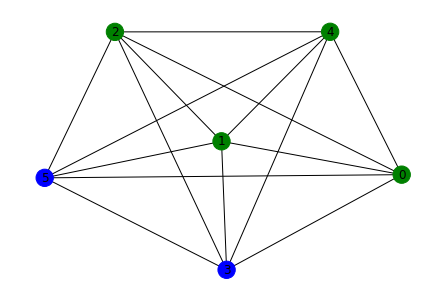

In [15]:
fm_tuples = []
run_time = N * (N-1)/2 
i = 0
while i!=run_time:
  print("ITERATION #", i)
  newA,newB,cut_size = FM_partitioning(N,dim,adj_matrix)
  new_areaA = area(newA,dim)
  new_areaB = area(newB,dim)
  new_rf = rf(new_areaA, new_areaB)
  fm_tuples.append((cut_size,new_rf,newA,newB))
  i = i+1
res = min(fm_tuples)
grp1 = res[2] 
grp2 = res[3]
G = nx.Graph()
for i in range(N):
  for j in range(N):
    if(adj_matrix[i][j]!=0):
      G.add_edge(i,j)
for n in G.nodes():
  G.nodes[n]['color'] = 'b' if n in grp1 else 'g'
colors = [node[1]['color'] for node in G.nodes(data=True)]
nx.draw(G, with_labels=True, node_color=colors)


In [16]:
print("Combination with minimum cut size and ratio factor", "\n", "Partition A = ", res[2], " ", "Partition B = ", res[3], " ", "cut size", cut_size, " ", "ratio-factor",new_rf)

Combination with minimum cut size and ratio factor 
 Partition A =  [3, 5]   Partition B =  [1, 2, 4, 0]   cut size 12   ratio-factor 0.1574074074074074


Plotting the rectangular blocks according to the above partition:

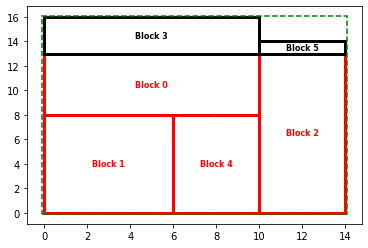

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# hardcoded for the current case
#define Matplotlib figure and axis
fig, ax = plt.subplots()
ax.plot([0, 10],[0, 10], color = 'white', lw=0.1)
#add rectangle to plot
ax.add_patch(Rectangle((0, 0), 6, 8, edgecolor = 'red', fill = False, lw=3))
ax.annotate("Block 1", (3, 4), color='red', weight='bold', fontsize=8, ha='center', va='center')
ax.add_patch(Rectangle((6, 0), 4, 8, edgecolor = 'red', fill = False, lw=3))
ax.annotate("Block 4", (8, 4), color='red', weight='bold', fontsize=8, ha='center', va='center')
ax.add_patch(Rectangle((10, 0), 4, 13, edgecolor = 'red', fill = False, lw=3))
ax.annotate("Block 2", (12, 6.5), color='red', weight='bold', fontsize=8, ha='center', va='center')
ax.add_patch(Rectangle((0, 8), 10, 5, edgecolor = 'red', fill = False, lw=3))
ax.annotate("Block 0", (5, 10.5), color='red', weight='bold', fontsize=8, ha='center', va='center')
ax.add_patch(Rectangle((0, 13), 10, 3, edgecolor = 'black', fill = False, lw=3))
ax.annotate("Block 3", (5, 14.5), color='black', weight='bold', fontsize=8, ha='center', va='center')
ax.add_patch(Rectangle((10, 13), 4, 1, edgecolor = 'black', fill = False, lw=3))
ax.annotate("Block 5", (12, 13.5), color='black', weight='bold', fontsize=8, ha='center', va='center')
ax.add_patch(Rectangle((-0.1, -0.1), 14.15, 16.15, edgecolor = 'green', fill = False, lw=1.5, ls = '--'))
#plt.legend()
#display plot
plt.show()    